# README

This notebook implements a complete workflow for processing chromatin contact distance data from multiple samples, starting from raw `.pairs` files and ending with visual analysis. The purpose is to demonstrate how to extract, convert and analyse contact frequency as a function of genomic distance for different tissues and developmental stages.

The main sections of the notebook are:

1. **Initialization and constant definitions**  
    In cell 2 common modules (`os`, `gzip`, `subprocess`, `numpy`, `pandas`, `multiprocessing`) are imported and global variables are defined:
    - `resolution`: resolution in base pairs (1 Mb).
    - `sampleid_list`: list of sample identifiers.
    - `sub_tissue_list` and `color_dict`: tissue names and plotting colours.
    - `save_dir` and `pairs_dir`: output directory and source pairs directory.

2. **Generating tissue‑specific pairs files**  
    Cell 3 defines the `extract_tissue_pairs` function, which reads each spot’s `.contact.tsv.gz`, extracts chromosome pairs and writes them to a `.onechrom.pairs` file. The code iterates over all samples and tissue labels, using multiprocessing to produce all combinations of pairs files.

3. **JuicerTools and hic2cool conversion**  
    Cell 4 defines `pairs2cool`, calling JuicerTools to convert `.pairs` to `.hic` and then `hic2cool` to convert to `.cool`. All pairs files produced above are processed in parallel.

4. **Computing contact frequency**  
    Cell 5 loads `cooler` and `cooltools` and loops through each sample’s cool files:
    - balance the cooler,
    - build a `view_df` covering all chromosomes,
    - compute cis‑expected values, smooth and aggregate,
    - filter and add distance information, then save to `Contact_Distance.{sample}.tsv`.

5. **Plotting per‑sample line plots**  
    Cell 6 uses `scanpy`, `seaborn` and `matplotlib` to draw contact‑distance curves for each tissue in each sample, saving a PNG.

6. **Combined plot of all samples**  
    Cell 7 overlays curves from all developmental stages onto a single figure and saves a PDF.

7. **Detail plots for selected samples**  
    Cell 8 re‑plots a subset of representative samples for a “main” figure, saved as PNG.

---

## Usage notes

- Ensure JuicerTools, hic2cool and other required tools are available in the environment.
- Data directories and sample naming must match the `save_dir` and `pairs_dir` variables.
- Cells may be executed sequentially or in whole to generate intermediate files and final results/figures.

This notebook serves as an example chromatin contact analysis pipeline; adjust sample lists, paths and plotting parameters to fit a specific project.

In [36]:
import os
import gzip
import subprocess
import numpy as np
import pandas as pd
import multiprocessing

resolution = 1_000_000
sampleid_list = [
    'E11.5L1', 'E11.5L2',
    'E12.5L5', 'E12.5L6', 'E12.5L9', 'E12.5S1',
    'E13.5C1', 'E13.5C4', 'E13.5C6', 
    'E14.5F5', 'E14.5F6', 'E14.5L7', 'E14.5L8', 'E14.5L10']
sub_tissue_list = ['Brain', 'Liver']

# 黄(#e8ac2d)：脑，红(#ef6666)：肝，蓝(#6fcce8 #129adb #9cdadb #53adcf #858ede #70a1ff #4f6dff)：其他
color_dict = {'Brain': '#e8ac2d', 'Liver': '#ef6666', 'Other': '#6fcce8'}

save_dir = '/home/xuyuetong/CRICK_Data_v3/Paper_Fig/'
pairs_dir = '/home/goubo/CRICK/CRICK/spaceA/hagash_pre_v2/'


In [ ]:
# Prepare Tissue Pairs

def extract_tissue_pairs(sample_id, save_path, spotid_list, pairs_dir):
    with open(save_path, 'w') as s:
        s.write('## pairs format v1.0\n')
        s.write('#columns: readID chr1 position1 chr2 position2 strand1 strand2\n')
        for spot_id in spotid_list:
            pairs_spot_path = '{0}{1}/{2}.contact.tsv.gz'.format(pairs_dir, sample_id, spot_id)
            with gzip.open(pairs_spot_path, 'rt') as sp:
                for line in sp:
                    lines = line.strip().split('\t')
                    line = '\t'.join([lines[1], lines[3]]) + '\n'
                    s.write('. chr1 {0} chr1 {1} . .\n'.format(lines[1], lines[3]))

                    
params_list = []
for s, sample_id in enumerate(sampleid_list):
    label_path = '{0}{1}_hagashi_obs_sub.tsv'.format(save_dir, sample_id)
    label_data = pd.read_csv(label_path, header=0, index_col=None, sep='\t')
    label_data = label_data[['spot_id', 'sample', 'hagashi_leiden_anno_man']]
    label_data['hagashi_leiden_anno_man'] = label_data['hagashi_leiden_anno_man'].replace('Unknown', 'Other')
    label_set = sorted(label_data['hagashi_leiden_anno_man'].unique())
    for label_i in label_set:
        label_idata = label_data[label_data['hagashi_leiden_anno_man'] == label_i]
        spotid_ilist = label_idata['spot_id'].values
        params_list.append((sample_id, label_i, spotid_ilist))

processes_num = len(params_list)
max_processes = 100
processes = []
index = 0
while index < processes_num:
    for _ in range(min(max_processes, processes_num - index)):
        sample_id, label_id, spotid_ilist = params_list[index]
        save_ipath = '{0}Contact_Distance_v2/Tissue_Pairs/{1}_{2}.onechrom.pairs'.format(
            save_dir, sample_id, label_id)
        p = multiprocessing.Process(target=extract_tissue_pairs, args=(
            sample_id, save_ipath, spotid_ilist, pairs_dir))
        p.start()
        processes.append(p)
        index += 1
    for p in processes:
        p.join()
    processes = []

In [ ]:
# Juicer Tools Pre and hic2cool to convert the pairs into cool format.

def pairs2cool(pairs_path, save_hic, save_cool, resolution):
    subprocess.run("java -Xmx2g -jar /home/xuyuetong/Tools/JuicerTools/juicer_tools_1.22.01.jar pre {0} {1} mm10 -r {2} -j 30".format(
        pairs_path, save_hic, resolution), shell=True)
    subprocess.run("hic2cool convert {0} {1} -p 30".format(save_hic, save_cool), shell=True)


pairs_dir = '{0}Contact_Distance_v2/Tissue_Pairs/'.format(save_dir)
pairs_path_list = []
for root, dirs, files in os.walk(pairs_dir):
    for file_name in files:
        pairs_path_list.append(file_name)

processes_num = len(pairs_path_list)
max_processes = 100
processes = []
index = 0
while index < processes_num:
    for _ in range(min(max_processes, processes_num - index)):
        pairs_path_i = pairs_path_list[index]
        sample_id = pairs_path_i.split('_')[0]
        label_id = pairs_path_i.split('_')[1].split('.')[0]
        pairs_path_i = os.path.join(pairs_dir, pairs_path_i)
        save_hic = '{0}Contact_Distance_v2/Tissue_HiC/{1}_{2}.onechrom.hic'.format(
            save_dir, sample_id, label_id)
        save_cool = '{0}Contact_Distance_v2/Tissue_Cool/{1}_{2}.onechrom.cool'.format(
            save_dir, sample_id, label_id)
        p = multiprocessing.Process(target=pairs2cool, args=(
            pairs_path_i, save_hic, save_cool, resolution))
        p.start()
        processes.append(p)
        index += 1
    for p in processes:
        p.join()
    processes = []


In [ ]:
import cooler
import cooltools

# This script calculates the contact frequency for different contact distances at the genome level for each tissue.

for s, sample_id in enumerate(sampleid_list):

    expected_data = pd.DataFrame()

    cool_dir = '{0}Contact_Distance_v2/Tissue_Cool/'.format(save_dir)
    pairs_path_list = []
    for root, dirs, files in os.walk(cool_dir):
        for file_name in files:
            if sample_id == file_name.split('_')[0]:
                cluster_id = file_name.split('_')[1].split('.')[0]
                cool_path = '{0}{1}'.format(cool_dir, file_name)
                print(file_name, sample_id, cluster_id)

                clr = cooler.Cooler(cool_path)
                cooler.balance_cooler(clr, cis_only=True, store=True)

                view_df = pd.DataFrame({'chrom': clr.chromnames,
                                        'start': 0,
                                        'end': clr.chromsizes.values,
                                        'name': clr.chromnames})

                cvd = cooltools.expected_cis(clr=clr, view_df=view_df, smooth=True, aggregate_smoothed=True, nproc=10)
                cvd = cvd[(cvd['dist'] >= 2) & (cvd['count.sum'] > 0)]
                cvd['s_bp'] = cvd['dist'] * resolution
                cvd['label'] = [cluster_id] * cvd.shape[0]
                expected_data = pd.concat([expected_data, cvd])
    expected_data = expected_data.dropna(subset=['balanced.avg.smoothed'])
    expected_data = expected_data.loc[:, ['s_bp', 'balanced.avg.smoothed', 'label']]
    distance_path = '{0}Contact_Distance_v2/Contact_Distance/Contact_Distance.{1}.tsv'.format(
        save_dir, sample_id)
    expected_data.to_csv(distance_path, header=True, index=False, sep='\t')

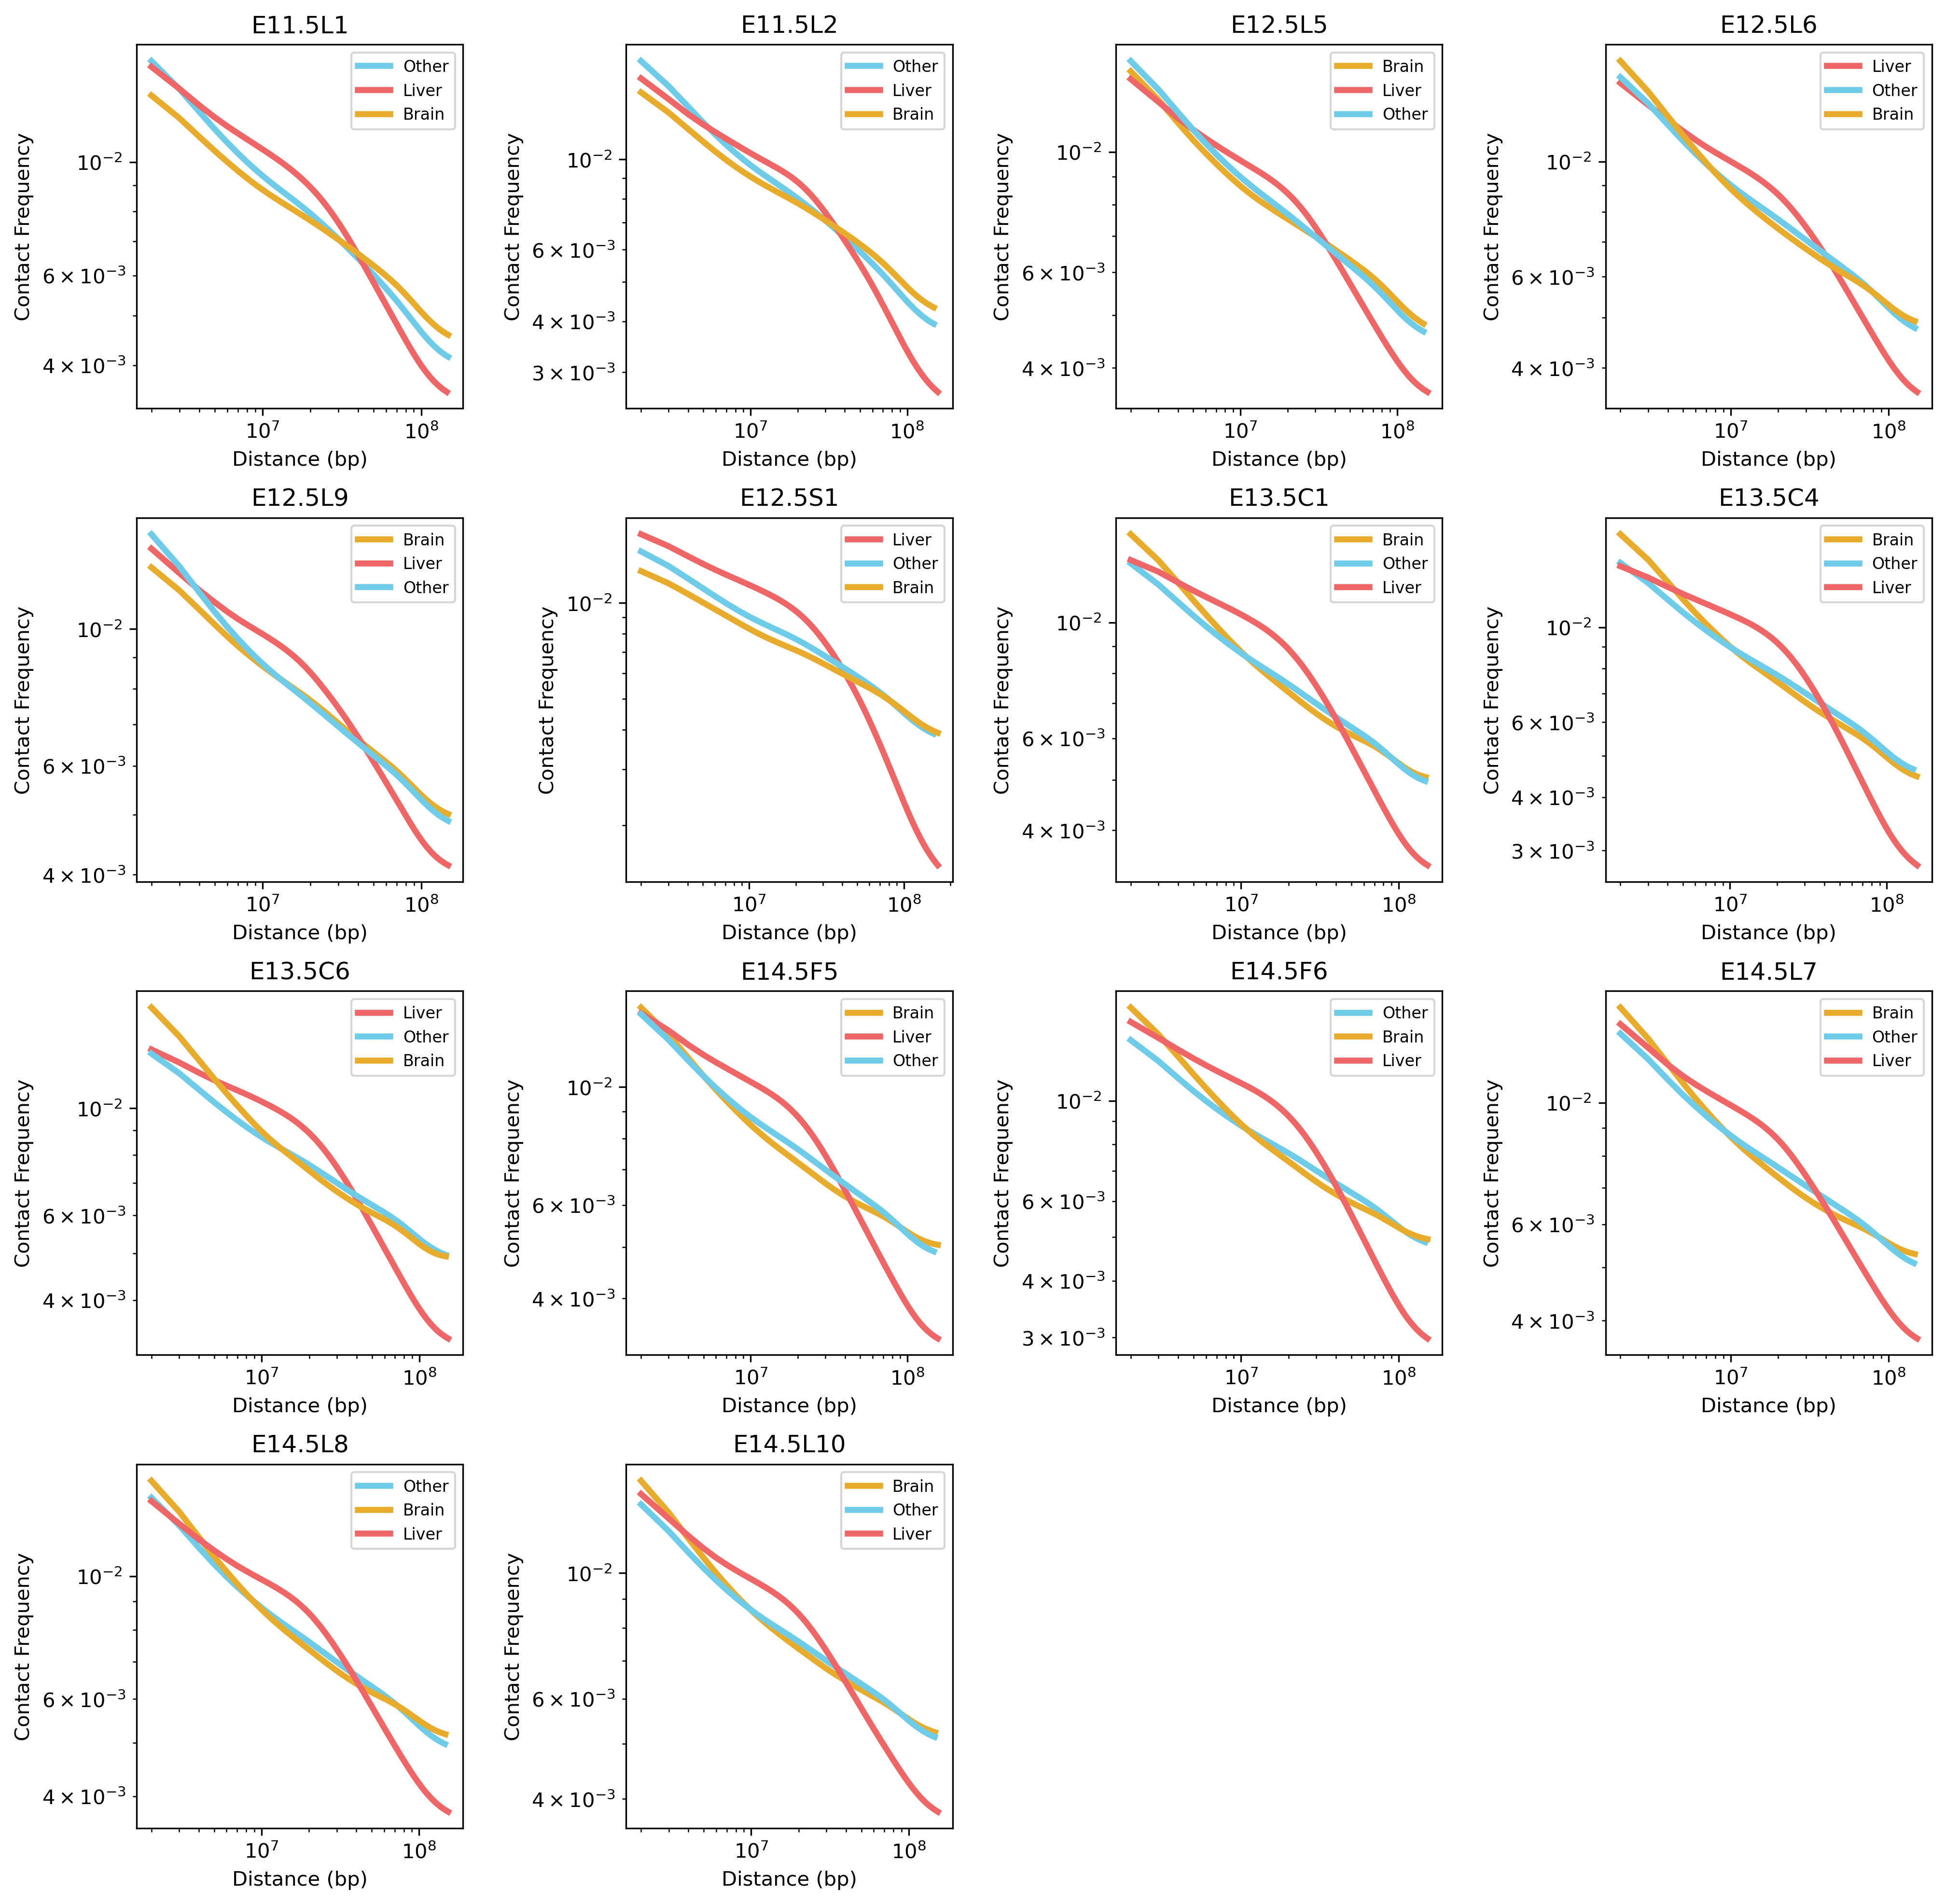

In [ ]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
mpl.rcParams['pdf.fonttype'] = 42


row_num = 4
col_num = 4
fig = plt.figure(figsize=(4*row_num, 4*col_num), dpi=300)
gs = plt.GridSpec(row_num, col_num, hspace=0.3, wspace=0.5)

for s, sample_id in enumerate(sampleid_list):

    distance_path = '{0}Contact_Distance_v2/Contact_Distance/Contact_Distance.{1}.tsv'.format(
        save_dir, sample_id)
    expected_data = pd.read_csv(distance_path, header=0, sep='\t')

    row_idx = s//col_num
    col_idx = s%col_num
    ax_line = fig.add_subplot(gs[row_idx, col_idx])
    sns.lineplot(expected_data, x='s_bp', y='balanced.avg.smoothed', hue='label', 
                 palette=color_dict, lw=3, ax=ax_line)
    ax_line.set_xscale('log')
    ax_line.set_yscale('log')
    ax_line.set_xlabel('Distance (bp)', fontsize=10)
    ax_line.set_ylabel('Contact Frequency', fontsize=10)
    ax_line.set_title(sample_id, fontsize=12)
    ax_line.legend(fontsize=8)

plot_path = '{0}Contact_Distance_v2/Contact_Distance/Lineplot_ContactDistance.png'.format(save_dir)
plt.savefig(plot_path)

In [ ]:
# 将所有时期样本绘制在同一张折线图上

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
mpl.rcParams['pdf.fonttype'] = 42


fig = plt.figure(figsize=(3.3, 3))
ax_line = fig.add_subplot(111)

for s, sample_id in enumerate(sampleid_list):

    distance_path = '{0}Contact_Distance_v2/Contact_Distance/Contact_Distance.{1}.tsv'.format(
        save_dir, sample_id)
    expected_data = pd.read_csv(distance_path, header=0, sep='\t')

    row_idx = s//col_num
    col_idx = s%col_num
    
    sns.lineplot(expected_data, x='s_bp', y='balanced.avg.smoothed', hue='label', 
                 palette=color_dict, lw=1, ax=ax_line)
    
ax_line.set_xscale('log')
ax_line.set_yscale('log')
ax_line.set_xlabel('Distance (bp)', fontsize=10)
ax_line.set_ylabel('Contact Frequency', fontsize=10)
ax_line.set_title('All Sample', fontsize=12)
ax_line.get_legend().remove()
plt.tight_layout()

plot_path = '{0}Contact_Distance_v2/Contact_Distance/Lineplot_AllSample_ContactDistance.pdf'.format(save_dir)
plt.savefig(plot_path)

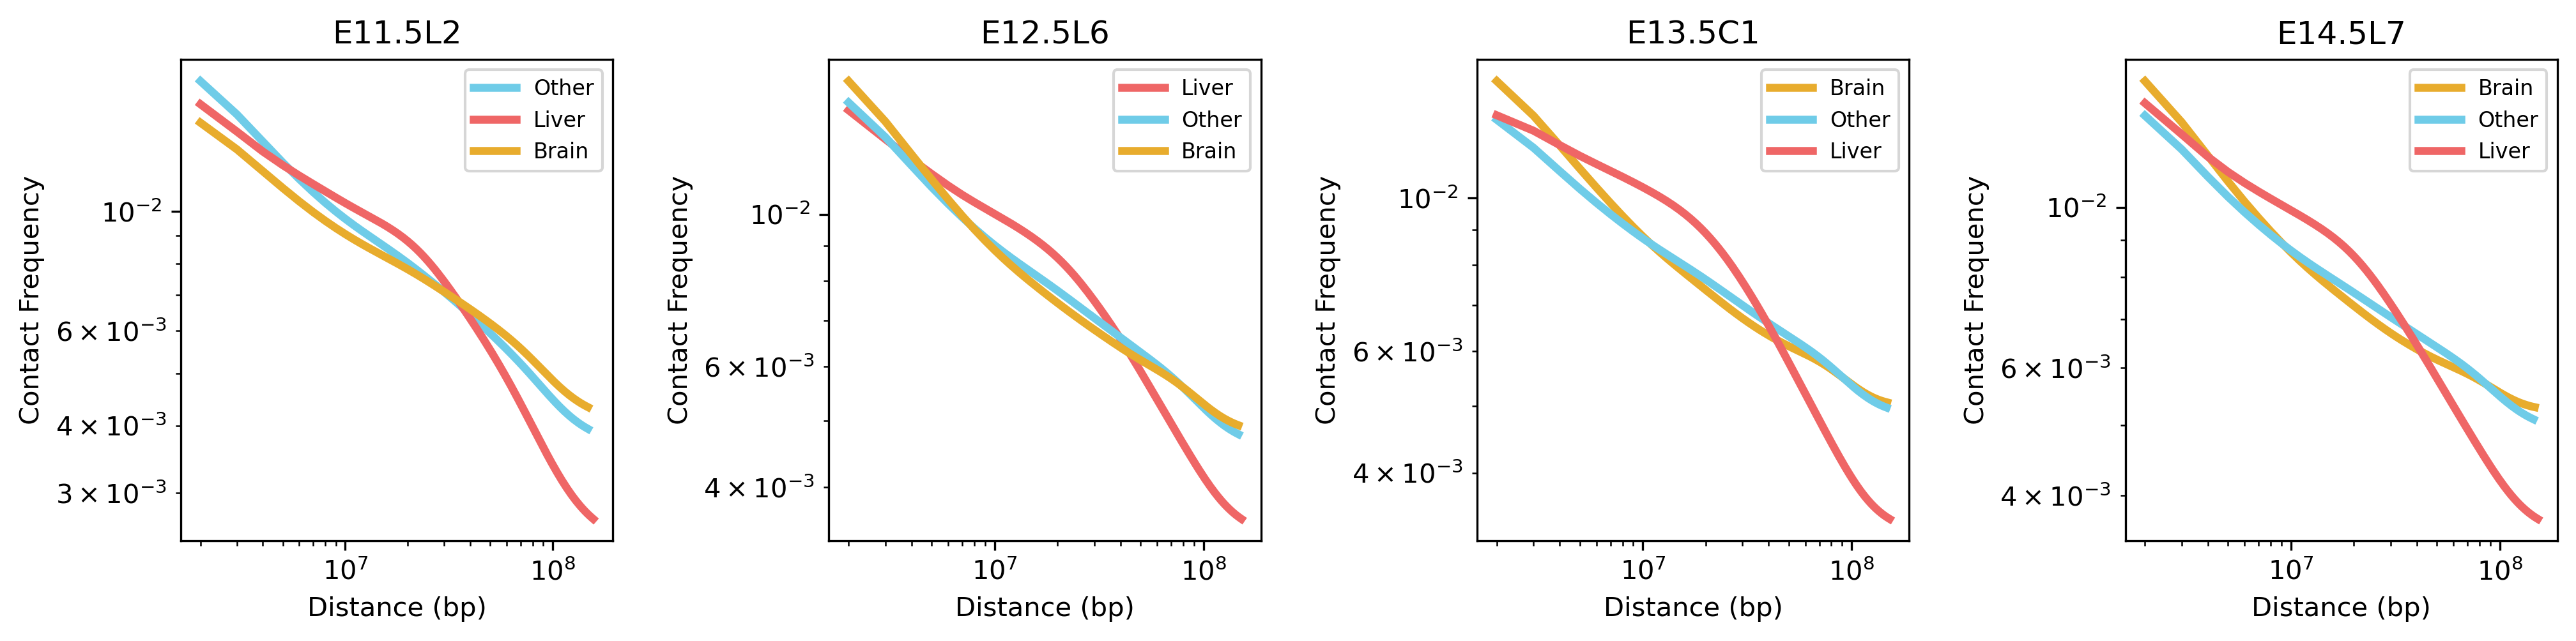

In [ ]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
mpl.rcParams['pdf.fonttype'] = 42


sampleid_list = ['E11.5L2', 'E12.5L6', 'E13.5C1', 'E14.5L7']

row_num = 4
col_num = 4
fig = plt.figure(figsize=(4*row_num, 4*col_num), dpi=300)
gs = plt.GridSpec(row_num, col_num, hspace=0.3, wspace=0.5)

for s, sample_id in enumerate(sampleid_list):

    distance_path = '{0}Contact_Distance_v2/Contact_Distance/Contact_Distance.{1}.tsv'.format(save_dir, sample_id)
    expected_data = pd.read_csv(distance_path, header=0, sep='\t')

    row_idx = s//col_num
    col_idx = s%col_num
    ax_line = fig.add_subplot(gs[row_idx, col_idx])
    sns.lineplot(expected_data, x='s_bp', y='balanced.avg.smoothed', hue='label', 
                 palette=color_dict, lw=3, ax=ax_line)
    ax_line.set_xscale('log')
    ax_line.set_yscale('log')
    ax_line.set_xlabel('Distance (bp)', fontsize=10)
    ax_line.set_ylabel('Contact Frequency', fontsize=10)
    ax_line.set_title(sample_id, fontsize=12)
    ax_line.legend(fontsize=8)

plot_path = '{0}Contact_Distance_v2/Contact_Distance/Lineplot_Main_ContactDistance.png'.format(save_dir)
plt.savefig(plot_path)